# 다양한 OCR 모델 비교하기

## 데이터셋 준비

도로에서 마주칠 수 있는 교통 표지판 또는 쇼핑몰 안내 표지판을 인식하는 성능을 비교하기 위해 이미지 12장을 준비합니다. 자율주행 차량에서 지도 데이터를 통해 쉽게 알 수 있는 정보들과 더불어 지도 상에 존재하는 정보만으로는 알기 힘든 주차 정보나 쇼핑몰 정보도 OCR을 적용하여 목적지를 찾아가는 데 도움이 될 수 있을 것입니다.

In [1]:
import os
import glob

ROOT_PATH = os.path.join(os.getenv("HOME"), "aiffel")
img_files = glob.glob(ROOT_PATH + "/ocr_python/img/*.jpg")
img_files

['/aiffel/aiffel/ocr_python/img/memorialsign.jpg',
 '/aiffel/aiffel/ocr_python/img/green-direction-uk-road-sign.jpg',
 '/aiffel/aiffel/ocr_python/img/priority.jpg',
 '/aiffel/aiffel/ocr_python/img/park_commons_mall.jpg',
 '/aiffel/aiffel/ocr_python/img/brown-tourist-sign-on-road.jpg',
 '/aiffel/aiffel/ocr_python/img/red_route.jpg',
 '/aiffel/aiffel/ocr_python/img/Ottawa-HW-Summer.jpg',
 '/aiffel/aiffel/ocr_python/img/pacific_hwy.jpg',
 '/aiffel/aiffel/ocr_python/img/roadworks-end-sign.jpg',
 '/aiffel/aiffel/ocr_python/img/motorway.jpg',
 '/aiffel/aiffel/ocr_python/img/welcome_nsw.jpg',
 '/aiffel/aiffel/ocr_python/img/primary.jpg']

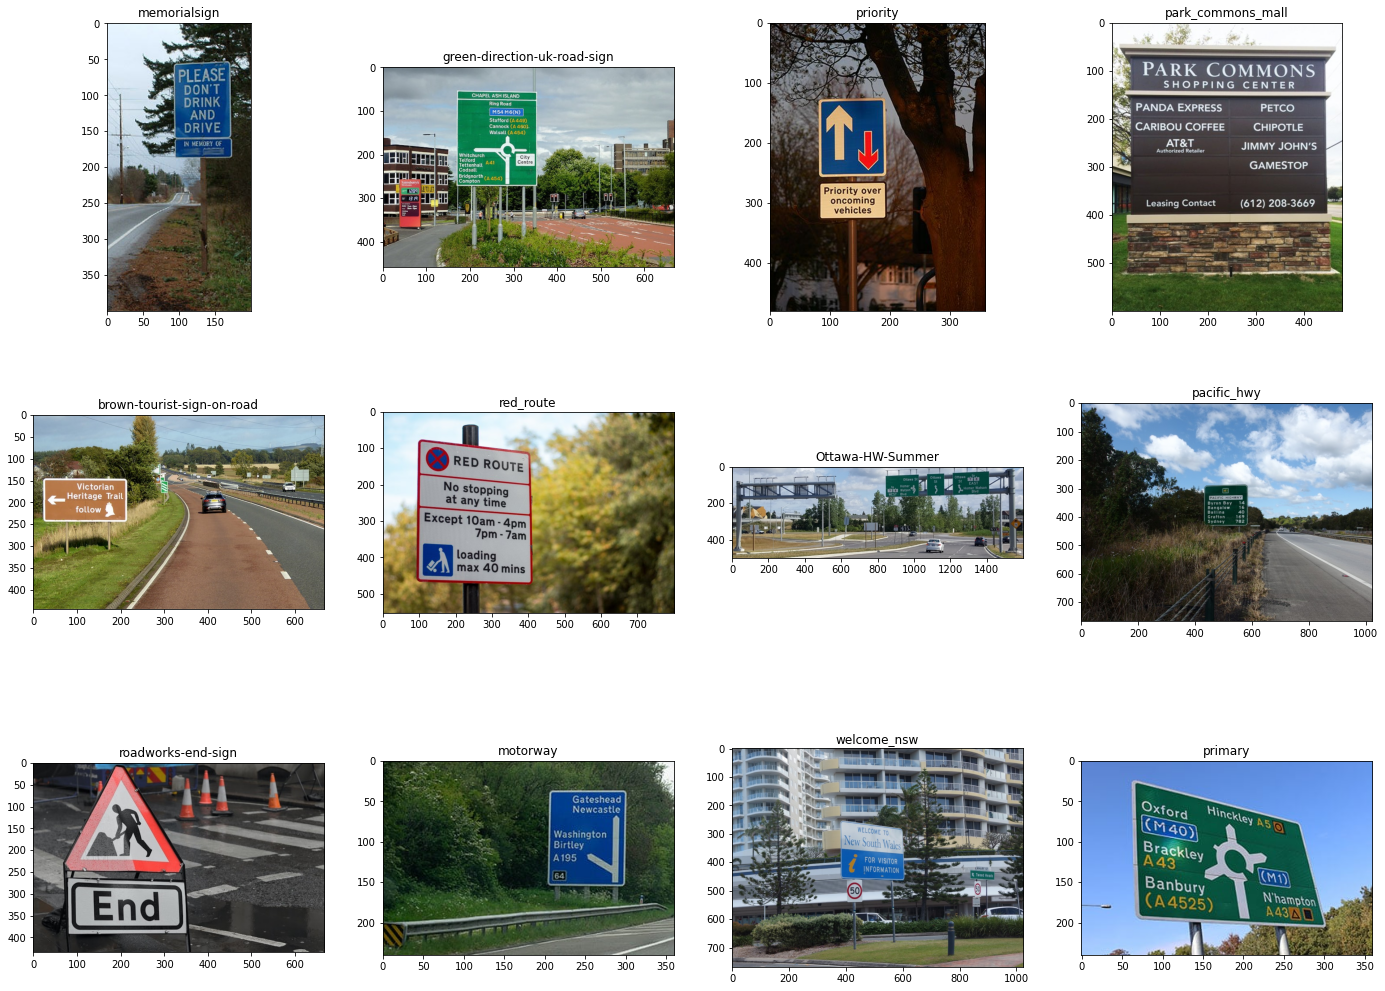

In [2]:
import cv2
import matplotlib.pyplot as plt


imgs = []
fnames = []

plt.figure(figsize=(24, 18))
for i in range(len(img_files)):
    fname = os.path.basename(img_files[i]).split(".")[0]
    fnames.append(fname)
    img = cv2.imread(img_files[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs.append(img)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(fname)

## OCR 모델 테스트

### Keras-OCR

keras-ocr에서는 문자가 존재하는 영역을 찾기 위한 모델로는 [CRAFT](https://github.com/clovaai/CRAFT-pytorch)를, 영역 내부에 존재하는 문자를 인식하는 모델로는 CRNN을 기본 모델로 사용합니다.

In [3]:
import keras_ocr

pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


테스트 데이터에 대한 모델 예측 결과를 확인합니다.

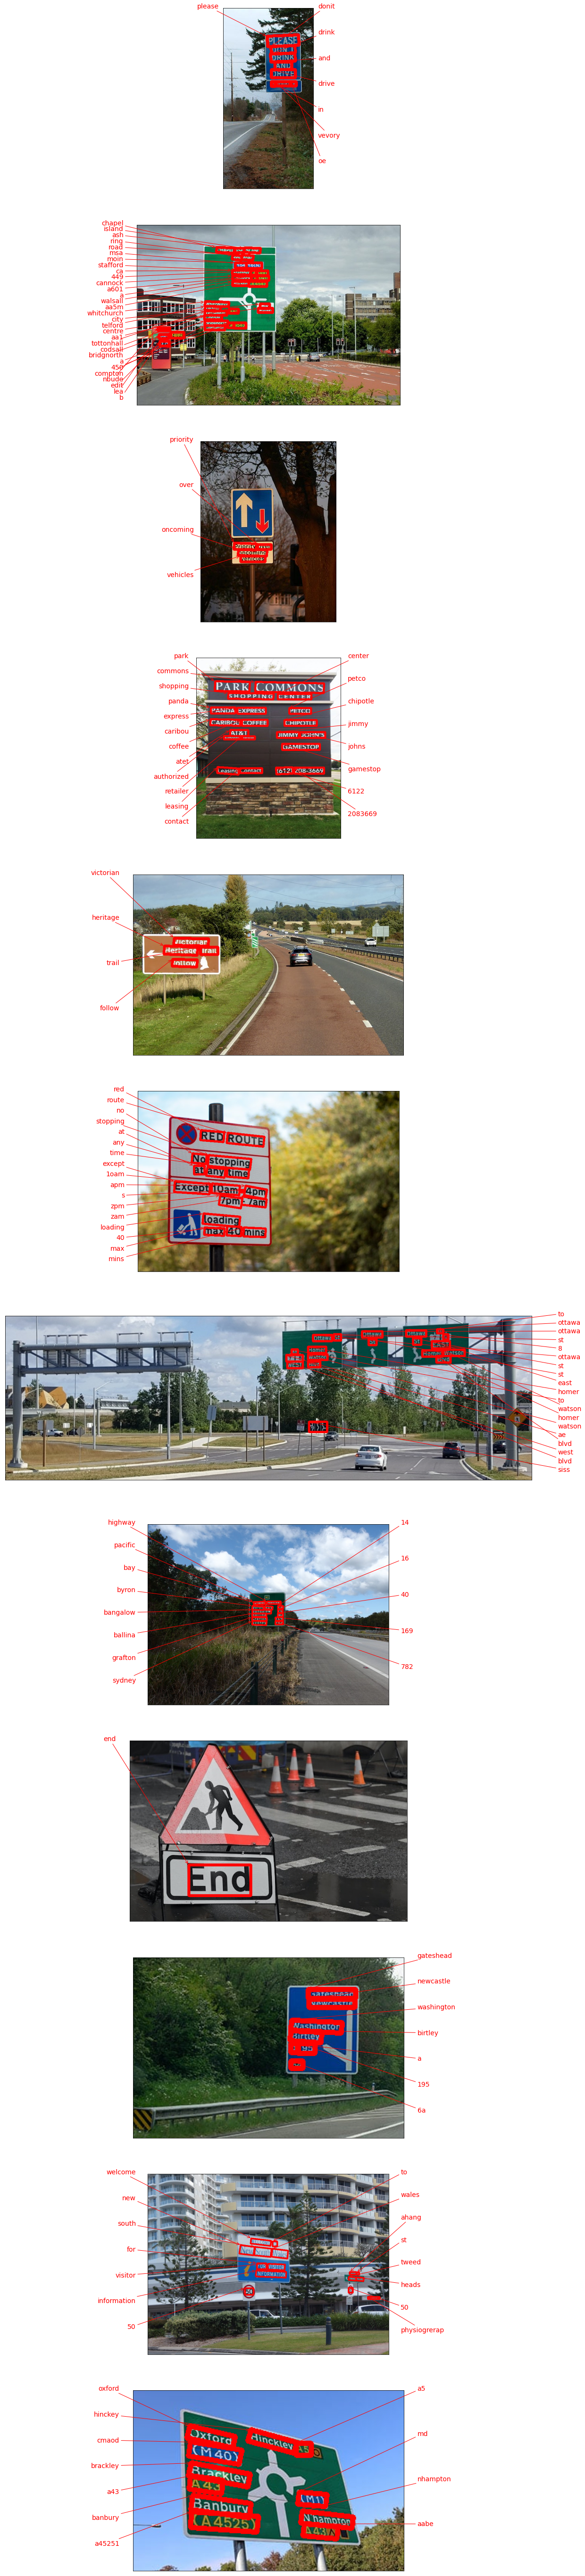

In [4]:
prediction_groups = [pipeline.recognize([f]) for f in img_files]

fig, axs = plt.subplots(nrows=len(imgs), figsize=(20, 100))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(
        image=imgs[idx], predictions=prediction_groups[idx][0], ax=ax
    )

### Tesseract

테서랙트는 오픈소스로 공개된 OCR 엔진으로 2006년부터는 구글의 후원을 받고 있습니다. 이전에는 딥러닝 모델을 사용하지 않았으나, 특정 버전 이후로는 LSTM과 같은 딥러닝 모델을 포함하고 있습니다.

In [5]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.


def crop_word_regions(image_path="./images/sample.png", output_path="./output"):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r"--oem 3 --psm 3"
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image,
        lang="eng",  # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT,
    )

    top_level = max(recognized_data["level"])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data["level"])):
        level = recognized_data["level"][i]

        if level == top_level:
            left = recognized_data["left"][i]
            top = recognized_data["top"][i]
            width = recognized_data["width"][i]
            height = recognized_data["height"][i]

            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            #             print(output_img_path)
            cropped_image = image.crop((left, top, left + width, top + height))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [6]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r"--oem 3 --psm 7"

    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image,
            lang="eng",  # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT,
        )
        print(recognized_data["text"])
    print("Done")

In [7]:
for img_f, fname in zip(img_files, fnames):
    output_path = os.getcwd() + "/tes_cropped" + fname
    os.makedirs(output_path, exist_ok=True)
    print(f"\n===={fname}====")
    cropped_image_path_list = crop_word_regions(img_f, output_path)
    recognize_images(cropped_image_path_list)


====memorialsign====
DRINK


Done

====green-direction-uk-road-sign====
iy aliay

Stafford |

_annock

qi

O60)

cles tm

a : ‘

Done

====priority====

Done

====park_commons_mall====
PARK

(COMMONS

he

SHOPPING

CENTER

PANDA

EXPRESS

4 ae

CARIBOU

COFFEE

CHIPOTLE

sl.

JIMMY

ele);

vs

a

GAMESTOP

a


Leasing

( ontact

(ou 4

208-3669

a


Done

====brown-tourist-sign-on-road====
Victorian

reritage

ic

ige

lie-tit


7 ; a - om

Done

====red_route====

No

Stopping

at

any

time

Except

10am

|

4pm

7pm

—

Tam

C

loading

5.

max

40

mins

Done

====Ottawa-HW-Summer====
ia

a a ge = — —,,

Done

====pacific_hwy====


M1]

Syron Say


=r-ne

ih

sSalilina

Cig-baaqes

Sydney

os

Done

====roadworks-end-sign====

Done

====motorway====

Done

====welcome_nsw====
Tie

5}

Done

====primary====
Soret

ire


FOr

eee

Braek

Osan)

Bae

O}

a

Banbury

PRET ete

OWT DT

ay

Done


## 테스트 결과 비교

![result](img/e15_res.png)

## 결과 분석 및 결론

keras-ocr과 tesseract의 검출 성능에는 많은 차이가 있었습니다.  
우선 recognition 결과 이전에 영역을 탐지하는 detection 에서 tesseract는 실패하는 경우가 많았습니다. 또는 tesseract는 결과를 전혀 출력하지 못하는 경우가 존재하였습니다. 또한 검출한 영역에 대한 recognition 결과도 텍스트가 제대로 일치하지 않는 경우를 보였습니다.  
반면 keras-ocr은 문자가 아닌 영역을 오검출하는 경우도 존재하지만, 대부분의 문자 영역 검출에 성공하였습니다. 다만, 글자체에 따라 문장 기호 또는 숫자들을 문자로 잘못 인식하는 경우가 존재하였습니다.  
쇼핑몰 안내를 제대로 인식하기 위해서는 놓치는 상점이 있어서는 안되며, 주차 안내 표지판의 경우 숫자가 중요한 정보이기 때문에 이를 놓쳐서는 안됩니다. 따라서 목표로 하는 기능을 만들기 위해서는 2개의 엔진 중 keras-ocr을 선택하는 것이 합리적으로 보입니다. 문자 영역 검출에 대해서는 성능이 부족하지 않으니 추가적인 조치는 필요하지 않아보이지만, 문자 인식에 대해서는 다양한 폰트와 문장 기호, 그리고 숫자에 대한 추가적인 훈련이나 전처리 또는 후처리를 적용하면 더 나은 성능을 보일 것으로 기대됩니다.

## 루브릭

| 평가문항 | 상세기준 | 
| --- | --- |
| 1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가? | 목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다. |
| 2. 모델 평가기준이 명확하고 체계적으로 세워졌는가? | 평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다. |
| 3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가? | 최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준 에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다. |

### 루브릭 자체평가

1. OCR을 적용하면 더 나은 서비스를 제공할 수 있다.
2. 적용하고자 하는 서비스에서 중요한 성능을 제시하고, 비교하였다.
3. 12장의 이미지를 사용하여 테스트를 진행하였고, 테스트 결과를 정리하였다.